## General information

In this kernel I'll try various technics for models interpretability and feature selection. Also I'll compare various models.

I use the features from my dataset: https://www.kaggle.com/artgor/lanl-features

This dataset was created using this kernel: https://www.kaggle.com/artgor/even-more-features/

*work in progress*

![](https://torontoseoulcialite.com/wp-content/uploads/2016/02/zimbiocom.jpg)

In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn import svm
import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn import neighbors
from sklearn.metrics import mean_absolute_error
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import ExtraTreesRegressor

from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import NearestNeighbors
import librosa, librosa.display
import builtins
from sklearn.ensemble import RandomForestRegressor
import eli5
import shap
from sklearn.feature_selection import GenericUnivariateSelect, SelectPercentile, SelectKBest, f_classif, mutual_info_classif, RFE

importing and setting up altair

In [2]:
import altair as alt
from  altair.vega import v3
from IPython.display import HTML
import json
# Preparing altair. I use code from this great kernel: https://www.kaggle.com/notslush/altair-visualization-2018-stackoverflow-survey

vega_url = 'https://cdn.jsdelivr.net/npm/vega@' + v3.SCHEMA_VERSION
vega_lib_url = 'https://cdn.jsdelivr.net/npm/vega-lib'
vega_lite_url = 'https://cdn.jsdelivr.net/npm/vega-lite@' + alt.SCHEMA_VERSION
vega_embed_url = 'https://cdn.jsdelivr.net/npm/vega-embed@3'
noext = "?noext"

paths = {
    'vega': vega_url + noext,
    'vega-lib': vega_lib_url + noext,
    'vega-lite': vega_lite_url + noext,
    'vega-embed': vega_embed_url + noext
}

workaround = """
requirejs.config({{
    baseUrl: 'https://cdn.jsdelivr.net/npm/',
    paths: {}
}});
"""

#------------------------------------------------ Defs for future rendering
def add_autoincrement(render_func):
    # Keep track of unique <div/> IDs
    cache = {}
    def wrapped(chart, id="vega-chart", autoincrement=True):
        if autoincrement:
            if id in cache:
                counter = 1 + cache[id]
                cache[id] = counter
            else:
                cache[id] = 0
            actual_id = id if cache[id] == 0 else id + '-' + str(cache[id])
        else:
            if id not in cache:
                cache[id] = 0
            actual_id = id
        return render_func(chart, id=actual_id)
    # Cache will stay outside and 
    return wrapped
            
@add_autoincrement
def render(chart, id="vega-chart"):
    chart_str = """
    <div id="{id}"></div><script>
    require(["vega-embed"], function(vg_embed) {{
        const spec = {chart};     
        vg_embed("#{id}", spec, {{defaultStyle: true}}).catch(console.warn);
        console.log("anything?");
    }});
    console.log("really...anything?");
    </script>
    """
    return HTML(
        chart_str.format(
            id=id,
            chart=json.dumps(chart) if isinstance(chart, dict) else chart.to_json(indent=None)
        )
    )

HTML("".join((
    "<script>",
    workaround.format(json.dumps(paths)),
    "</script>",
)))

In [3]:
os.listdir('../input/lanl-features')

['test_features_denoised.csv',
 'submission_1.csv',
 'train_features_denoised.csv',
 'train_features.csv',
 'y.csv',
 'test_features.csv']

* 'train_features.csv' - train features generated on original data
* 'train_features_denoised.csv' - train features generated on denoised data
* 'test_features.csv' - test features generated on original data
* 'test_features_denoised.csv' - test features generated on denoised data
* 'submission_1.csv' - one of my local submissions
* 'y.csv' - train target

## Loading data
Let's load features!

In [4]:
train_features = pd.read_csv('../input/lanl-features/train_features.csv')
test_features = pd.read_csv('../input/lanl-features/test_features.csv')
train_features_denoised = pd.read_csv('../input/lanl-features/train_features_denoised.csv')
test_features_denoised = pd.read_csv('../input/lanl-features/test_features_denoised.csv')
train_features_denoised.columns = [f'{i}_denoised' for i in train_features_denoised.columns]
test_features_denoised.columns = [f'{i}_denoised' for i in test_features_denoised.columns]
y = pd.read_csv('../input/lanl-features/y.csv')

In [5]:
X = pd.concat([train_features, train_features_denoised], axis=1).drop(['seg_id_denoised', 'target_denoised'], axis=1)
X_test = pd.concat([test_features, test_features_denoised], axis=1).drop(['seg_id_denoised', 'target_denoised'], axis=1)
X = X[:-1]
y = y[:-1]

We have almost 2000 features here!

In [6]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=False, random_state=11)

## Training function

Training function is in the hidden cell below

In [7]:
def train_model(X, X_test, y, params, folds, model_type='lgb', plot_feature_importance=False, model=None):

    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        if type(X) == np.ndarray:
            X_train, X_valid = X[train_index], X[valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 50000, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae',
                    verbose=10000, early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = mean_absolute_error(y_valid, y_pred_valid)
            print(f'Fold {fold_n}. MAE: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric='MAE', **params, loss_function='MAE')
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_absolute_error(y_valid, y_pred_valid))

        prediction += y_pred    
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= n_fold
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof, prediction, feature_importance
        return oof, prediction, scores
    
    else:
        return oof, prediction, scores

## First model

Fold 0 started at Mon Apr 29 18:54:26 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[426]	training's l1: 1.47112	valid_1's l1: 2.13769
Fold 1 started at Mon Apr 29 18:54:41 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1490]	training's l1: 0.733195	valid_1's l1: 2.36235
Fold 2 started at Mon Apr 29 18:55:13 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[215]	training's l1: 1.68535	valid_1's l1: 2.36869
Fold 3 started at Mon Apr 29 18:55:23 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[242]	training's l1: 1.8649	valid_1's l1: 1.336
Fold 4 started at Mon Apr 29 18:55:34 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[154]	training's l1: 1.82756	valid_1's l1: 2.44648
CV mean score: 2.1302, std: 0.4103.


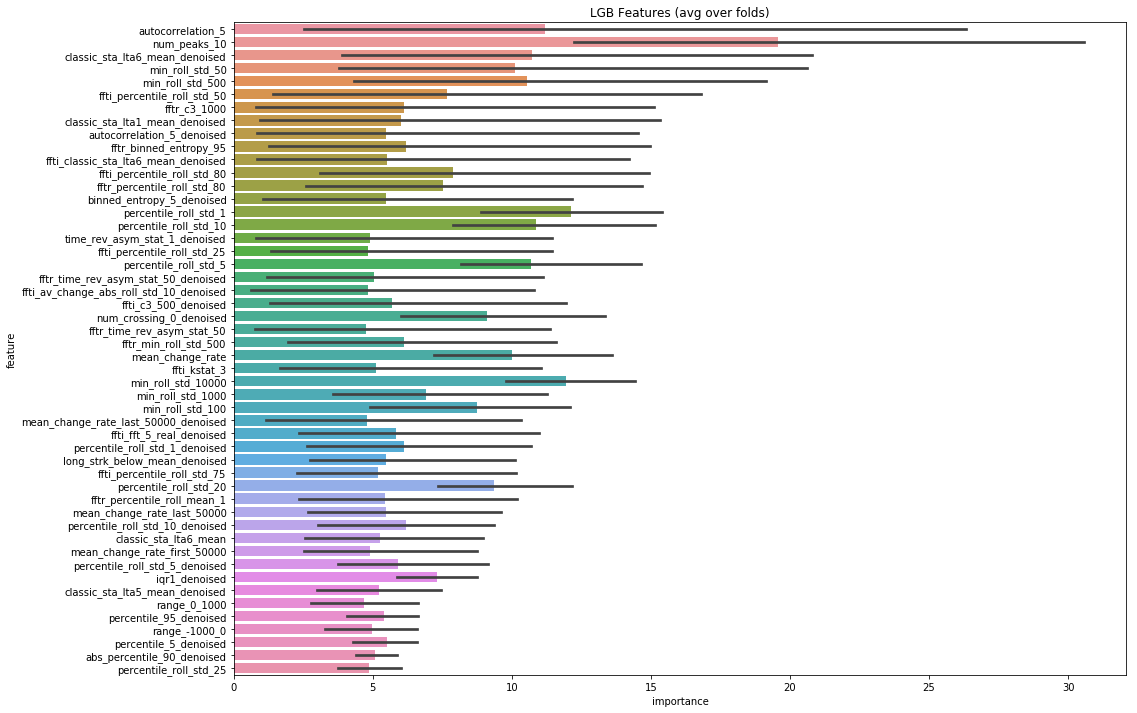

In [8]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'gamma',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "subsample_freq": 5,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501,
          'colsample_bytree': 0.1
         }
oof_lgb, prediction_lgb, feature_importance = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)

In [9]:
submission = pd.read_csv('../input/LANL-Earthquake-Prediction/sample_submission.csv', index_col='seg_id')
submission['time_to_failure'] = prediction_lgb
print(submission.head())
submission.to_csv('submission.csv')

              time_to_failure
seg_id                       
seg_00030f  4.103821633725794
seg_0012b5  4.742040094768816
seg_00184e  5.750404042156748
seg_003339  8.390957574025270
seg_0042cc  6.924418924733668


In [10]:
sub1 = pd.read_csv('../input/lanl-features/submission_1.csv')
sub1.to_csv('submission_1.csv', index=False)

## NN features
Here I normalize the data and create features using NearestNeighbors. The idea is to find samples which are similar and use it to generate features.

In [11]:
scaler = StandardScaler()
scaler.fit(X)
X_train_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [12]:
%%time
n = 10
neigh = NearestNeighbors(n, n_jobs=-1)
neigh.fit(X_train_scaled)

dists, _ = neigh.kneighbors(X_train_scaled, n_neighbors=n)
mean_dist = dists.mean(axis=1)
max_dist = dists.max(axis=1)
min_dist = dists.min(axis=1)

X_train_scaled['mean_dist'] = mean_dist
X_train_scaled['max_dist'] = max_dist
X_train_scaled['min_dist'] = min_dist

test_dists, _ = neigh.kneighbors(X_test_scaled, n_neighbors=n)

test_mean_dist = test_dists.mean(axis=1)
test_max_dist = test_dists.max(axis=1)
test_min_dist = test_dists.min(axis=1)

X_test_scaled['mean_dist'] = test_mean_dist
X_test_scaled['max_dist'] = test_max_dist
X_test_scaled['min_dist'] = test_min_dist


CPU times: user 3min 13s, sys: 216 ms, total: 3min 13s
Wall time: 49.5 s


Fold 0 started at Mon Apr 29 18:56:38 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[396]	training's l1: 1.54755	valid_1's l1: 2.14458
Fold 1 started at Mon Apr 29 18:56:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[1086]	training's l1: 0.998815	valid_1's l1: 2.37497
Fold 2 started at Mon Apr 29 18:57:12 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[194]	training's l1: 1.7462	valid_1's l1: 2.366
Fold 3 started at Mon Apr 29 18:57:20 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[346]	training's l1: 1.76309	valid_1's l1: 1.32718
Fold 4 started at Mon Apr 29 18:57:31 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[162]	training's l1: 1.82931	valid_1's l1: 2.43661
CV mean score: 2.1299, std: 0.4134.


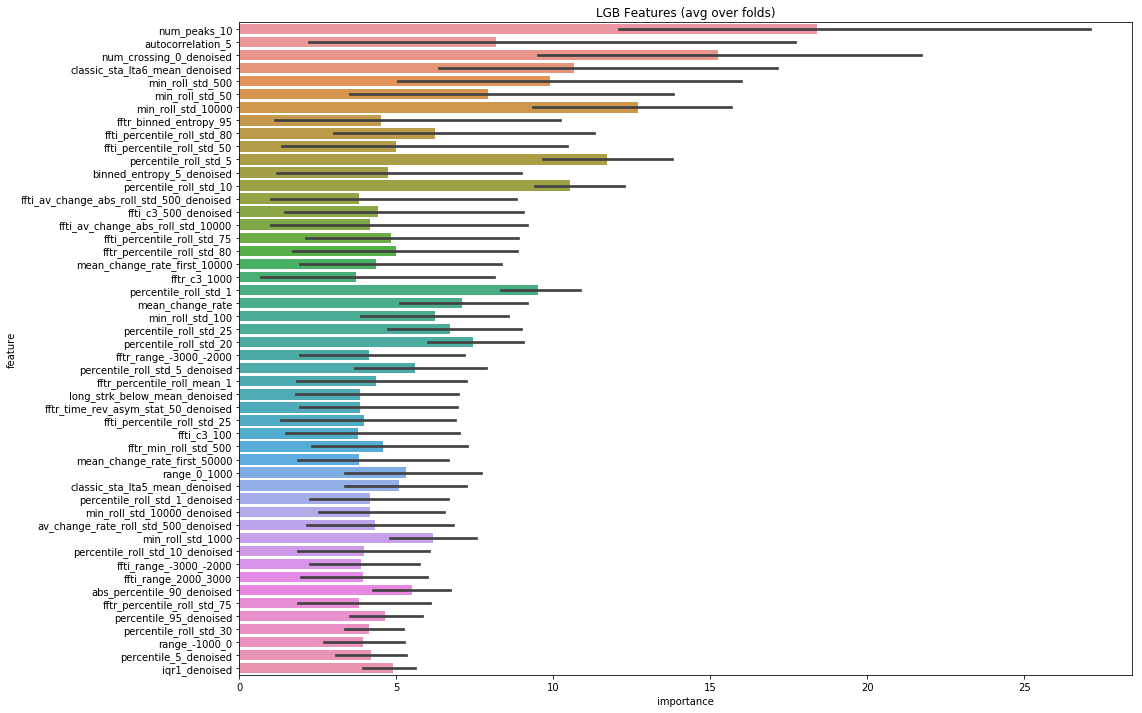

In [13]:
params = {'num_leaves': 32,
          'min_data_in_leaf': 79,
          'objective': 'gamma',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting": "gbdt",
          "bagging_freq": 5,
          "bagging_fraction": 0.8126672064208567,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501,
          'feature_fraction': 0.1
         }
oof_lgb, prediction_lgb, feature_importance = train_model(X_train_scaled, X_test_scaled, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)

In [14]:
submission['time_to_failure'] = prediction_lgb
submission.to_csv('submission_nn.csv')

## Model interpretation


### ELI5 and permutation importance
ELI5 is a package with provides explanations for ML models. It can do this not only for linear models, but also for tree based like Random Forest or lightgbm.

**Important notice**: running eli5 on all features takes a lot of time, so I run the cell below in `version 14` and printed the top-50 features. In the following versions I'll use these 50 columns and use eli5 to find top-40 of them so that it takes less time

In [15]:
top_columns = ['iqr1_denoised', 'percentile_5_denoised', 'abs_percentile_90_denoised', 'percentile_95_denoised', 'ave_roll_std_10', 'num_peaks_10', 'percentile_roll_std_20',
               'ratio_unique_values_denoised', 'fftr_percentile_roll_std_75_denoised', 'num_crossing_0_denoised', 'percentile_95', 'ffti_percentile_roll_std_75_denoised',
               'min_roll_std_10000', 'percentile_roll_std_1', 'percentile_roll_std_10', 'fftr_percentile_roll_std_70_denoised', 'ave_roll_std_50', 'ffti_percentile_roll_std_70_denoised',
               'exp_Moving_std_300_mean_denoised', 'ffti_percentile_roll_std_30_denoised', 'mean_change_rate', 'percentile_roll_std_5', 'range_-1000_0', 'mad',
               'fftr_range_1000_2000_denoised', 'percentile_10_denoised', 'ffti_percentile_roll_std_80', 'percentile_roll_std_25', 'fftr_percentile_10_denoised',
               'ffti_range_-2000_-1000_denoised', 'autocorrelation_5', 'min_roll_std_100', 'fftr_percentile_roll_std_80', 'min_roll_std_500', 'min_roll_std_50', 'min_roll_std_1000',
               'ffti_percentile_20_denoised', 'iqr1', 'classic_sta_lta5_mean_denoised', 'classic_sta_lta6_mean_denoised', 'percentile_roll_std_10_denoised',
               'fftr_percentile_70_denoised', 'ffti_c3_50_denoised', 'ffti_percentile_roll_std_75', 'abs_percentile_90', 'range_0_1000', 'spkt_welch_density_50_denoised',
               'ffti_percentile_roll_std_40_denoised', 'ffti_range_-4000_-3000', 'mean_change_rate_last_50000']


X_train, X_valid, y_train, y_valid = train_test_split(X[top_columns], y, test_size=0.1)
model = lgb.LGBMRegressor(**params, n_estimators = 50000, n_jobs = -1, verbose=-1)
model.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric='mae',
        verbose=10000, early_stopping_rounds=200)

perm = eli5.sklearn.PermutationImportance(model, random_state=1).fit(X_train, y_train)

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[678]	training's l1: 1.72085	valid_1's l1: 2.08288


In [16]:
eli5.show_weights(perm, top=50, feature_names=top_columns)

Weight,Feature
0.0439 ± 0.0053,num_crossing_0_denoised
0.0262 ± 0.0022,num_peaks_10
0.0173 ± 0.0019,percentile_roll_std_10
0.0167 ± 0.0016,abs_percentile_90_denoised
0.0167 ± 0.0024,percentile_95_denoised
0.0159 ± 0.0018,percentile_roll_std_5
0.0152 ± 0.0015,percentile_5_denoised
0.0136 ± 0.0015,percentile_roll_std_1
0.0130 ± 0.0012,min_roll_std_10000
0.0118 ± 0.0005,min_roll_std_500


Fold 0 started at Mon Apr 29 18:58:06 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[509]	training's l1: 1.82517	valid_1's l1: 2.10304
Fold 1 started at Mon Apr 29 18:58:07 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[466]	training's l1: 1.78597	valid_1's l1: 2.3992
Fold 2 started at Mon Apr 29 18:58:08 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[178]	training's l1: 1.93805	valid_1's l1: 2.38108
Fold 3 started at Mon Apr 29 18:58:09 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[397]	training's l1: 2.05381	valid_1's l1: 1.33861
Fold 4 started at Mon Apr 29 18:58:10 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[253]	training's l1: 1.88352	valid_1's l1: 2.4109
CV mean score: 2.1266, std: 0.4102.


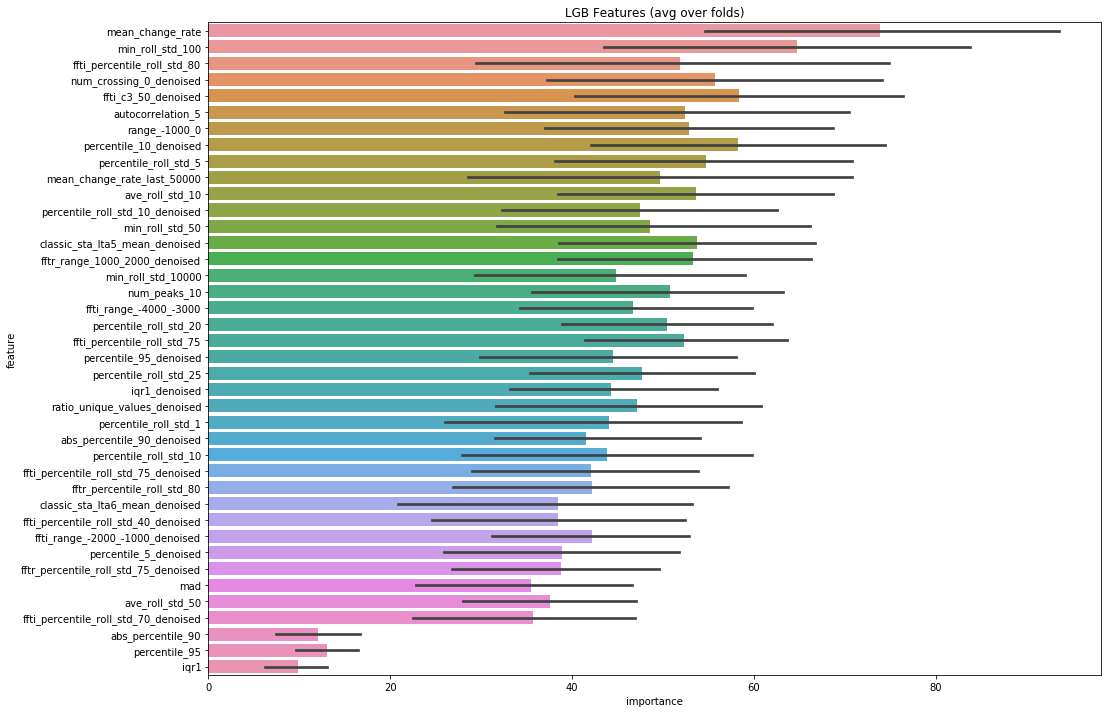

In [17]:
top_features = [i for i in eli5.formatters.as_dataframe.explain_weights_df(model).feature if 'BIAS' not in i][:40]
oof_lgb, prediction_lgb, feature_importance = train_model(X[top_features], X_test[top_features], y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)

In [18]:
submission['time_to_failure'] = prediction_lgb
submission.to_csv('submission_eli5.csv')

## Feature selection

Here I try various approaches to feature selection.

**Important notice**: running feature selection on all features takes a lot of time, so I'll run some of feature selection methods and print the result, which I'll use in the following versions of the kernel, so that I can explore more approaches.

In [19]:
params = {'num_leaves': 32,
          'min_child_samples': 79,
          'objective': 'gamma',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "subsample_freq": 5,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501,
          'colsample_bytree': 1.0
         }

### SelectPercentile

**Important notice**:  I run the cell below in `version 14` and printed the scores_dict. In the following versions I'll use `scores_dict` and plot the results instead of running feature selection each time

In [20]:
# %%time
# scores_dict = {'f_classif': [], 'mutual_info_classif': [], 'n_features': []}
# for i in range(5, 105, 5):
#     print(i)
#     s1 = SelectPercentile(f_classif, percentile=i)
#     X_train1 = s1.fit_transform(X, y.values.astype(int))
#     X_test1 = s1.transform(X_test)
#     oof, prediction, scores = train_model(X_train1, X_test1, y.values.reshape(-1, ), params=params, folds=folds, model_type='lgb', plot_feature_importance=False)
#     scores_dict['f_classif'].append(np.mean(scores))
    
#     s2 = SelectPercentile(mutual_info_classif, percentile=i)
#     X_train1 = s2.fit_transform(X, y.values.astype(int))
#     X_test1 = s2.transform(X_test)
#     oof, prediction, scores = train_model(X_train1, X_test1, y.values.reshape(-1, ), params=params, folds=folds, model_type='lgb', plot_feature_importance=False)
#     scores_dict['mutual_info_classif'].append(np.mean(scores))
    
#     scores_dict['n_features'].append(X_train1.shape[1])

In [21]:
scores_dict = {'f_classif': [2.0746468465171377, 2.0753843541953687, 2.062191535440333, 2.0654327826583034, 2.0643551320704936, 2.0617560048382675,
                             2.061565197738015, 2.0598878198917494, 2.0654865223333143, 2.0632788555735777, 2.058002635080971, 2.051075689018734,
                             2.0472543961304583, 2.052401474353084, 2.055924154798443, 2.0561794619762352, 2.0549680611994963, 2.057123777802326,
                             2.0591868861136904, 2.0577745274024553],
               'mutual_info_classif': [2.0866763775014006, 2.0745431497064324, 2.0564324832516427, 2.060125564781158, 2.067334544167612, 2.0665943783246448,
                                       2.063891669849029, 2.070194051004794, 2.0667490707700447, 2.0681653852378354, 2.0592743636982345, 2.061260741522344,
                                       2.05680667824411, 2.0565047875243003, 2.058252567141659, 2.0554927194831922, 2.0562776429736873, 2.0618179277444084,
                                       2.06364125584214, 2.0577745274024553],
               'n_features': [98, 196, 294, 392, 490, 588, 685, 783, 881, 979, 1077, 1175, 1273, 1370, 1468, 1566, 1664, 1762, 1860, 1958]}

In [22]:
scores_df = pd.DataFrame(scores_dict)
scores_df = scores_df.melt(id_vars=['n_features'], value_vars=['mutual_info_classif', 'f_classif'], var_name='metric', value_name='mae')
max_value = scores_df['mae'].max() * 1.05
min_value = scores_df['mae'].min() * 0.95
render(alt.Chart(scores_df).mark_line().encode(
    y=alt.Y('mae:Q', scale=alt.Scale(domain=(min_value, max_value))),
    x='n_features:O',
    color='metric:N',
    tooltip=['metric:N', 'n:O', 'mae:Q']
).properties(
    title='Top N features by SelectPercentile vs CV'
).interactive())

### SelectKBest

**Important notice**:  I run the cell below in `version 14` and printed the scores_dict. In the following versions I'll use `scores_dict` and plot the results instead of running feature selection each time

In [23]:
# %%time
# scores_dict = {'f_classif': [], 'mutual_info_classif': [], 'n_features': []}
# for i in np.arange(10, 1958, 100):
#     print(i)
#     s1 = SelectKBest(f_classif, k=i)
#     X_train1 = s1.fit_transform(X, y.values.astype(int))
#     X_test1 = s1.transform(X_test)
#     oof, prediction, scores = train_model(X_train1, X_test1, y.values.reshape(-1, ), params=params, folds=folds, model_type='lgb', plot_feature_importance=False)
#     scores_dict['f_classif'].append(np.mean(scores))
    
#     s2 = SelectKBest(mutual_info_classif, k=i)
#     X_train1 = s2.fit_transform(X, y.values.astype(int))
#     X_test1 = s2.transform(X_test)
#     oof, prediction, scores = train_model(X_train1, X_test1, y.values.reshape(-1, ), params=params, folds=folds, model_type='lgb', plot_feature_importance=False)
#     scores_dict['mutual_info_classif'].append(np.mean(scores))
    
#     scores_dict['n_features'].append(X_train1.shape[1])

In [24]:
scores_dict = {'f_classif': [2.1495892622081354, 2.0778182269587147, 2.0716153738740006, 2.06152950679902, 2.0645162758752553, 2.0627705797004032, 2.0610992303725157,
                             2.057762113735462, 2.0618360883613627, 2.0603197111525984, 2.06081274633874, 2.0580767195278056, 2.0527646572747127, 2.0498353445032533,
                             2.052442594925, 2.0564456881902133, 2.0582284644115365, 2.0558612960548635, 2.0580900016350094, 2.058218782401599],
               'mutual_info_classif': [2.1235703196243687, 2.084958198672301, 2.0596822478390955, 2.053305869981444, 2.063468853227225, 2.0674399950434323, 2.0658618511287874,
                                       2.063003703200445, 2.0653174905858664, 2.0644340327023656, 2.0748993062333523, 2.0587602096358113, 2.0601495560836076, 2.0559629138548603,
                                       2.0553852701221134, 2.058022171415446, 2.060755947658241, 2.057916705462307, 2.056245795262636, 2.0580691870837056],
               'n_features': [10, 110, 210, 310, 410, 510, 610, 710, 810, 910, 1010, 1110, 1210, 1310, 1410, 1510, 1610, 1710, 1810, 1910]}

In [25]:
scores_df = pd.DataFrame(scores_dict)
scores_df = scores_df.melt(id_vars=['n_features'], value_vars=['mutual_info_classif', 'f_classif'], var_name='metric', value_name='mae')
max_value = scores_df['mae'].max() * 1.05
min_value = scores_df['mae'].min() * 0.95
render(alt.Chart(scores_df).mark_line().encode(
    y=alt.Y('mae:Q', scale=alt.Scale(domain=(min_value, max_value))),
    x='n_features:O',
    color='metric:N',
    tooltip=['metric:N', 'n:O', 'mae:Q']
).properties(
    title='Top N features by SelectKBest vs CV'
).interactive())

### Dropping highly correlated features

Due to the huge number of features there are certainly some highly correlated features, let's try droping them!

Fold 0 started at Mon Apr 29 18:58:49 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[349]	training's l1: 1.44758	valid_1's l1: 2.14916
Fold 1 started at Mon Apr 29 18:59:25 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[712]	training's l1: 1.03142	valid_1's l1: 2.37431
Fold 2 started at Mon Apr 29 19:00:25 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[185]	training's l1: 1.66681	valid_1's l1: 2.35368
Fold 3 started at Mon Apr 29 19:00:50 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[278]	training's l1: 1.71156	valid_1's l1: 1.30914
Fold 4 started at Mon Apr 29 19:01:22 2019
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[170]	training's l1: 1.72337	valid_1's l1: 2.43712
CV mean score: 2.1247, std: 0.4191.


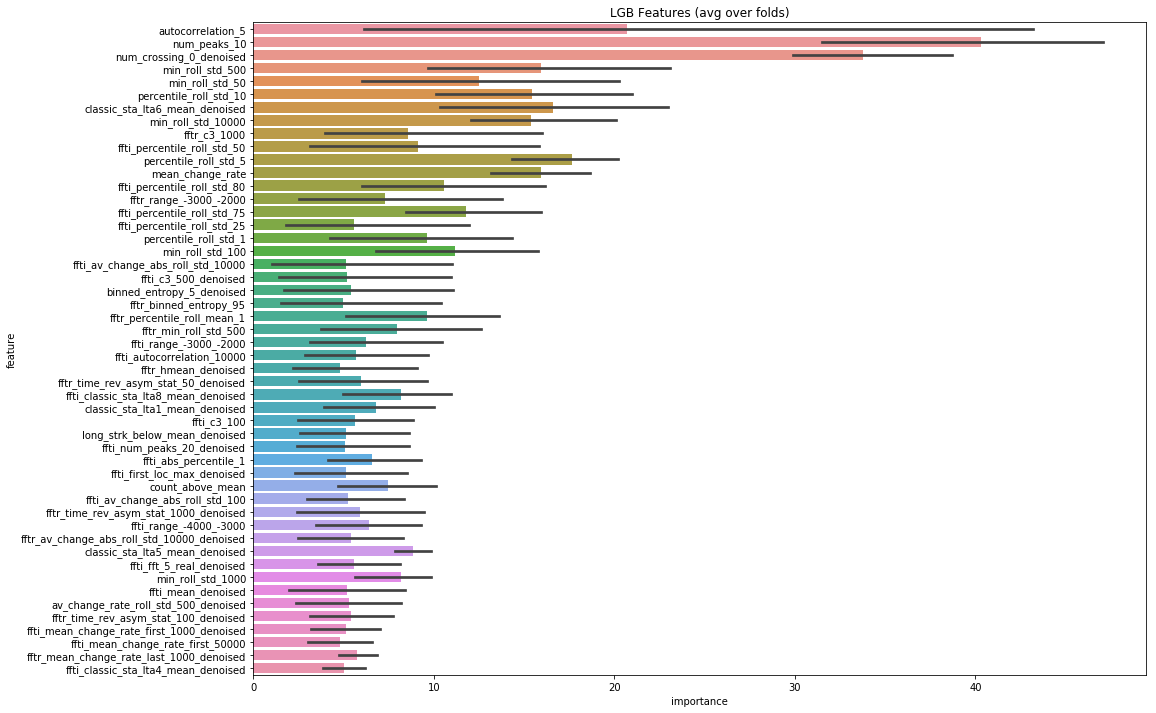

In [26]:
# https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
corr_matrix = X.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.99)]
X = X.drop(to_drop, axis=1)
X_test = X_test.drop(to_drop, axis=1)
oof_lgb, prediction_lgb, feature_importance = train_model(X, X_test, y, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)

In [27]:
submission['time_to_failure'] = prediction_lgb
submission.to_csv('submission_no_corr.csv')

### RFE


**Important notice**:  I run the cell below in `version 18` and printed the scores_dict. In the following versions I'll use `scores_dict` and plot the results instead of running feature selection each time

In [28]:
# %%time
# scores_dict = {'rfe_score': [], 'n_features': []}
# for i in np.arange(10, 1958, 100)[:3]:
#     print(i)
#     s1 = RFE(model, i, step=100)
#     X_train1 = s1.fit_transform(X, y.values.astype(int))
#     X_test1 = s1.transform(X_test)
#     oof, prediction, scores = train_model(X_train1, X_test1, y.values.reshape(-1, ), params=params, folds=folds, model_type='lgb', plot_feature_importance=False)
#     scores_dict['rfe_score'].append(np.mean(scores))
    
#     scores_dict['n_features'].append(X_train1.shape[1])

In [29]:
scores_df = {'rfe_score': [2.103586938061856, 2.052535910798748, 2.053228199447811], 'n_features': [10, 110, 210]}

In [30]:
scores_df = pd.DataFrame(scores_dict)
scores_df = scores_df.melt(id_vars=['n_features'], value_vars=['rfe_score'], var_name='metric', value_name='mae')
max_value = scores_df['mae'].max() * 1.05
min_value = scores_df['mae'].min() * 0.95
render(alt.Chart(scores_df).mark_line().encode(
    y=alt.Y('mae:Q', scale=alt.Scale(domain=(min_value, max_value))),
    x='n_features:O',
    color='metric:N',
    tooltip=['metric:N', 'n:O', 'mae:Q']
).properties(
    title='Top N features by SelectKBest vs CV'
).interactive())

## Model comparison

In this section I'll try variuos sklearn models and compair their score. Running GridSearchCV each time is too long, so I'll run it once for each model and use optimal parameters.

In [31]:
%%time
rfr = RandomForestRegressor()

# parameter_grid = {'n_estimators': [50, 60],
#                   'max_depth': [5, 10]
#                  }

# grid_search = GridSearchCV(rfr, param_grid=parameter_grid, cv=folds, scoring='neg_mean_absolute_error', n_jobs=-1)
# grid_search.fit(X, y)
# print('Best score: {}'.format(grid_search.best_score_))
# print('Best parameters: {}'.format(grid_search.best_params_))
# rfr = RandomForestRegressor(**grid_search.best_params_)
rfr = RandomForestRegressor(n_estimators=50, max_depth=5)
oof_rfr, prediction_rfr, scores_rfr = train_model(X, X_test, y, params=params, folds=folds, model_type='sklearn', model=rfr)
print(scores_rfr)

Fold 0 started at Mon Apr 29 19:01:49 2019
Fold 0. MAE: 2.0869.

Fold 1 started at Mon Apr 29 19:02:32 2019
Fold 1. MAE: 2.5159.

Fold 2 started at Mon Apr 29 19:03:14 2019
Fold 2. MAE: 2.4374.

Fold 3 started at Mon Apr 29 19:03:57 2019
Fold 3. MAE: 1.3664.

Fold 4 started at Mon Apr 29 19:04:40 2019
Fold 4. MAE: 2.6979.

CV mean score: 2.2209, std: 0.4711.
[2.086880341027696, 2.515901799626071, 2.437422285823906, 1.3664046391837392, 2.697909557375575]
CPU times: user 3min 33s, sys: 624 ms, total: 3min 33s
Wall time: 3min 33s


In [32]:
%%time
linreg = linear_model.LinearRegression(normalize=True, copy_X=True, n_jobs=-1)

# parameter_grid = {'n_estimators': [50, 60],
#                   'max_depth': [5, 10]
#                  }

# grid_search = GridSearchCV(rfr, param_grid=parameter_grid, cv=folds, scoring='neg_mean_absolute_error', n_jobs=-1)
# grid_search.fit(X, y)
# print('Best score: {}'.format(grid_search.best_score_))
# print('Best parameters: {}'.format(grid_search.best_params_))
# rfr = RandomForestRegressor(**grid_search.best_params_)
# rfr = RandomForestRegressor(n_estimators=50, max_depth=5)
oof_linreg, prediction_linreg, scores_linreg = train_model(X, X_test, y, params=params, folds=folds, model_type='sklearn', model=linreg)
# print(scores_linreg)

Fold 0 started at Mon Apr 29 19:05:23 2019
Fold 0. MAE: 40.9270.

Fold 1 started at Mon Apr 29 19:05:24 2019
Fold 1. MAE: 286.0885.

Fold 2 started at Mon Apr 29 19:05:25 2019
Fold 2. MAE: 70105.3339.

Fold 3 started at Mon Apr 29 19:05:26 2019
Fold 3. MAE: 1158.6108.

Fold 4 started at Mon Apr 29 19:05:27 2019
Fold 4. MAE: 8828925.6606.

CV mean score: 1780103.3242, std: 3524514.3007.
CPU times: user 6.63 s, sys: 3.53 s, total: 10.2 s
Wall time: 5.07 s


In [33]:
%%time
ridge = linear_model.Ridge(normalize=True)

parameter_grid = {'alpha': [0.1, 1.0, 10.0]}

grid_search = GridSearchCV(ridge, param_grid=parameter_grid, cv=folds, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X, y)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
ridge = linear_model.Ridge(**grid_search.best_params_, normalize=True)
oof_ridge, prediction_ridge, scores_ridge = train_model(X, X_test, y, params=params, folds=folds, model_type='sklearn', model=ridge)
# print(scores_ridge)

Best score: -2.2115612652185033
Best parameters: {'alpha': 1.0}
Fold 0 started at Mon Apr 29 19:05:40 2019
Fold 0. MAE: 2.1601.

Fold 1 started at Mon Apr 29 19:05:41 2019
Fold 1. MAE: 2.5332.

Fold 2 started at Mon Apr 29 19:05:42 2019
Fold 2. MAE: 2.4815.

Fold 3 started at Mon Apr 29 19:05:42 2019
Fold 3. MAE: 1.4187.

Fold 4 started at Mon Apr 29 19:05:43 2019
Fold 4. MAE: 2.4645.

CV mean score: 2.2116, std: 0.4175.
CPU times: user 5.35 s, sys: 5.55 s, total: 10.9 s
Wall time: 15.6 s


In [34]:
%%time
sgd = linear_model.SGDRegressor()

parameter_grid = {'loss': ['squared_loss', 'huber'],
                  'penalty': ['l1', 'l2', 'elasticnet'],
                  'alpha': [0.001, 0.01],
                  'l1_ratio': [0, 0.15, 0.5, 1.0],
                  'learning_rate': ['optimal', 'invscaling', 'adaptive']
                 }

grid_search = GridSearchCV(sgd, param_grid=parameter_grid, cv=folds, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X, y)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
sgd = linear_model.SGDRegressor(**grid_search.best_params_, normalize=True)
oof_sgd, prediction_sgd, scores_sgd = train_model(X, X_test, y, params=params, folds=folds, model_type='sklearn', model=sgd)

Best score: -2.0321090246946723e+32
Best parameters: {'alpha': 0.01, 'l1_ratio': 1.0, 'learning_rate': 'invscaling', 'loss': 'huber', 'penalty': 'l1'}


TypeError: __init__() got an unexpected keyword argument 'normalize'

In [35]:
%%time
knn = neighbors.KNeighborsRegressor()

parameter_grid = {'n_neighbors': [3, 5, 10, 50]}

grid_search = GridSearchCV(knn, param_grid=parameter_grid, cv=folds, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X, y)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
knn = neighbors.KNeighborsRegressor(**grid_search.best_params_)
oof_knn, prediction_knn, scores_knn = train_model(X, X_test, y, params=params, folds=folds, model_type='sklearn', model=knn)

Best score: -2.410506147183759
Best parameters: {'n_neighbors': 50}
Fold 0 started at Mon Apr 29 19:10:52 2019
Fold 0. MAE: 2.3823.

Fold 1 started at Mon Apr 29 19:10:54 2019
Fold 1. MAE: 2.5922.

Fold 2 started at Mon Apr 29 19:10:56 2019
Fold 2. MAE: 2.6232.

Fold 3 started at Mon Apr 29 19:10:58 2019
Fold 3. MAE: 1.7810.

Fold 4 started at Mon Apr 29 19:11:00 2019
Fold 4. MAE: 2.6741.

CV mean score: 2.4106, std: 0.3301.
CPU times: user 10.4 s, sys: 748 ms, total: 11.2 s
Wall time: 26.8 s


In [36]:
# %%time
svr = svm.SVR()

parameter_grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                  'C': [0.1, 1.0, 10.0]}

grid_search = GridSearchCV(svr, param_grid=parameter_grid, cv=folds, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X, y)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
svr = svm.SVR(**grid_search.best_params_)
oof_svr, prediction_svr, scores_svr = train_model(X, X_test, y, params=params, folds=folds, model_type='sklearn', model=svr)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [37]:
%%time
lasso = linear_model.Lasso(normalize=True)

parameter_grid = {'alpha': [0.1, 1.0, 10.0]}

grid_search = GridSearchCV(lasso, param_grid=parameter_grid, cv=folds, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X, y)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
lasso = linear_model.Lasso(**grid_search.best_params_, normalize=True)
oof_lasso, prediction_lasso, scores_lasso = train_model(X, X_test, y, params=params, folds=folds, model_type='sklearn', model=lasso)

Best score: -3.0576430853710503
Best parameters: {'alpha': 0.1}
Fold 0 started at Mon Apr 29 19:12:59 2019
Fold 0. MAE: 3.0867.

Fold 1 started at Mon Apr 29 19:13:00 2019
Fold 1. MAE: 3.2496.

Fold 2 started at Mon Apr 29 19:13:00 2019
Fold 2. MAE: 3.1006.

Fold 3 started at Mon Apr 29 19:13:01 2019
Fold 3. MAE: 2.5965.

Fold 4 started at Mon Apr 29 19:13:02 2019
Fold 4. MAE: 3.2551.

CV mean score: 3.0577, std: 0.2413.
CPU times: user 3.9 s, sys: 3.69 s, total: 7.59 s
Wall time: 13.9 s


In [38]:
%%time
etr = ExtraTreesRegressor()

parameter_grid = {'n_estimators': [50, 100, 200],
                  'max_depth': [5, 10, 20]
                 }

grid_search = GridSearchCV(rfr, param_grid=parameter_grid, cv=folds, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X, y)
print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
etr = ExtraTreesRegressor(**grid_search.best_params_)
oof_etr, prediction_etr, scores_etr = train_model(X, X_test, y, params=params, folds=folds, model_type='sklearn', model=etr)

Best score: -2.2170038290103746
Best parameters: {'max_depth': 5, 'n_estimators': 200}
Fold 0 started at Mon Apr 29 20:08:51 2019
Fold 0. MAE: 2.0838.

Fold 1 started at Mon Apr 29 20:09:14 2019
Fold 1. MAE: 2.5442.

Fold 2 started at Mon Apr 29 20:09:37 2019
Fold 2. MAE: 2.4211.

Fold 3 started at Mon Apr 29 20:09:59 2019
Fold 3. MAE: 1.3564.

Fold 4 started at Mon Apr 29 20:10:21 2019
Fold 4. MAE: 2.6986.

CV mean score: 2.2208, std: 0.4773.
CPU times: user 5min 27s, sys: 1.14 s, total: 5min 28s
Wall time: 57min 40s
